In [2]:
import matplotlib.pyplot as plt
import numpy as np
import io,os,sys
import datetime as dt
from h5py import File
import pandas as pd
import netCDF4 as nc
import scipy
import glob
import pdb
import geopandas as gpd
import cartopy.crs as ccrs
from pykdtree.kdtree import KDTree
from scipy.interpolate import interp1d

In [3]:
def sample_wrfout_profile(ID=None,wrf_domain='d01',wrf_path='',var_dict={}):
    """
    Description:        This function finds the wrfout files closest in time to a sample and
                        then locates the gridbox closest to the sample location from which it 
                        pulls the variables of interest.

    Inputs:
        wrf_domain      A string like d01 or d02 - controls which wrfout domain files you sample from
        wrf_path        Where the wrfout files are stored
        var_dict        Contains the physical locations and times to sample, can also contain 
                        vertical levels if vertical interpolation to preset levels in meters AGL is implied
                        Example: {'lat':[30],'lon':[-75],'datetime':datetime(2023,7,1,18,30),'levs':[10,100]}

    Returns:
        var_dict        Augmented dictionary with variables from the wrfout file of interest on vertical levels
    """
    files = sorted(glob.glob(f'{wrf_path}/*{wrf_domain}*'))
    wrfdatetime = [dt.datetime.strptime(fi.split(f'{wrf_domain}_')[-1],'%Y-%m-%d_%H:%M:%S') for fi in files]
    try:
        sample_lat = np.array(var_dict['lat'])
        sample_lon = np.array(var_dict['lon'])
        sample_dt = np.array(var_dict['datetime'])
    except KeyError:
        print("var_dict must contain at least one longitude, latitude, and datetime")
        return var_dict

#----
#   Find all of the wrfout files needed for the set of points and datetimes
    n_samples = len(sample_lat)
    wrf_files = []
    for i in range(n_samples):
        wrf_files.append(f"{wrf_path}/wrfout_{wrf_domain}_{sample_dt[i].strftime('%Y-%m-%d_%H')}:00:00")
    # Only loop over the unique filenames to save I/O
    unique_wrf_files = sorted(np.array(list(set(wrf_files))))

    f = nc.Dataset(wrf_files[0],'r')
    for v in var_dict:
        if v in ['lat','lon','datetime','levs']: continue
        if 'levs' in var_dict.keys():
            interp_levs = var_dict['levs']
            n_levs = len(interp_levs)
        else:
            n_levs = f['P'][:].shape[1]
        var_dict[v] = np.zeros((n_samples,n_levs))
    var_dict['wrf_files'] = np.array([None for i in range(n_samples)])
    for fi in unique_wrf_files:
        f = nc.Dataset(fi,'r')
        wrf_lat = f['XLAT'][:][0]
        wrf_lon = f['XLONG'][:][0]

        time_inds = np.where([fl == fi for fl in wrf_files])[0]
        part_lat = sample_lat[time_inds]
        part_lon = sample_lon[time_inds]
        part_points = np.float32(np.c_[part_lon,part_lat])
        
        # Define the KDTree to find the nearest neighbor latitude/longitude
        tree = KDTree(np.c_[wrf_lon.ravel(),wrf_lat.ravel()])
        dd,ii = tree.query(part_points,k=1,eps=0.0)
        lat_inds,lon_inds = np.unravel_index(ii,wrf_lat.shape,order='C')
        wrf_gph = (f['PH'][:] + f['PHB'][:])[0][:,lat_inds,lon_inds]
        wrf_z = wrf_gph/9.8
        wrf_zsurf = f['HGT'][:][0,lat_inds,lon_inds]

        # Sample the model at the lat/lon and vertical levels for each variable
        # If a variable name string is not in the wrfout file, a new elif statement
        # for computing it from variables in the file must be added below.
        var_dict['wrf_files'][time_inds] = np.array([fi for i in range(len(time_inds))])
        for v in var_dict.keys():
            if v == 'wrf_files': continue
            if 'levs' in var_dict.keys(): vert_interp = True
            if v in ['lat','lon','datetime','levs']: continue
            if v.lower() == 'pressure': 
                vwrf_smp = (f['P'][:][0]+f['PB'][:][0])[:,lat_inds,lon_inds].T
            elif v.lower() == 'psfc':
                vwrf_smp = f['PSFC'][:][0][lat_inds,lon_inds]
                vert_interp = False
            else:
                try:
                    vwrf = f[v][0]
                except KeyError:
                    print(f"{v} not defined")
                    continue
                if len(vwrf.shape) == 2:
                    vwrf_smp = vwrf[lat_inds,lon_inds]
                    vert_interp = False
                    for i,ind in enumerate(time_inds):
                        var_dict[v][ind,0] = vwrf_smp[i]
                    continue
                else:
                    vwrf_smp = vwrf[:,lat_inds,lon_inds].T
            if vert_interp:
                for i,ind in enumerate(time_inds):
                    vert_inds = np.where((interp_levs >= wrf_z[0,i])*(interp_levs <= wrf_z[-1,i]))[0]
                    var_dict[v][ind] = np.nan*np.zeros(len(interp_levs))
                    intpf = interp1d((wrf_z[:-1,i]-wrf_zsurf[i]).data,vwrf_smp[:,i].data)
                    var_dict[v][ind][vert_inds] = intpf(interp_levs[vert_inds])
            else:
                for i,ind in enumerate(time_inds):
                    var_dict[v][ind] = vwrf_smp[i]
    var_dict['ID'] = ID
    return var_dict

def compute_ak_col_avg(var_dict={}):
    """
    Takes in a list of files for a single latitude and longitude and computes the column average values
    for any variable in the keys of var_dict
    """
    
    prf_plevs = var_dict['prof_plevs'][:]
    prf_mf = var_dict['mole_frac'][:]
    ak_plevs = var_dict['ak_plevs'][:]
    ch4_ap = var_dict['ch4_ap'][:]
    ak_plevs_stretch = (prf_plevs[0]-prf_plevs[-1])/(ak_plevs[0]-ak_plevs[-1])*ak_plevs
    ak = var_dict['ak'][:]
    psfc = var_dict['psfc']

    #Compute the column values
    p_inds = np.argsort(prf_plevs)
    p_ext = [psfc]
    p_ext.extend(prf_plevs[p_inds][:-1]+0.5*np.diff(prf_plevs[p_inds]))
    p_ext.append(0)
    p_sort = np.array(p_ext)
    dp = []
    dp.extend(-np.diff(p_sort))
    dp = np.array(dp)
    
    intpf = interp1d(prf_plevs,prf_mf)
    prf_mf_int = intpf(ak_plevs)
    
    xch4_ak = ch4_ap.mean() + (ak*(prf_mf_int-ch4_ap)).mean()
    
    return xch4_ak

In [9]:
lat_lb = 38
lat_ub = 44
lon_lb = -77
lon_ub = -70
s5p_dir = '/scratch/07351/tg866507/s5p/staaqs_nyc/'
s5p_files = sorted(glob.glob(f'{s5p_dir}/*CH4____2023*.nc'))
print(s5p_files[:1])
f = File(s5p_files[1],'r')['PRODUCT']
f['SUPPORT_DATA']['INPUT_DATA'].keys()
#f['SUPPORT_DATA']['DETAILED_RESULTS'].keys()

['/scratch/07351/tg866507/s5p/staaqs_nyc/S5P_OFFL_L2__CH4____20230720T061151_20230720T075321_29877_03_020500_20230722T205020.nc']


<KeysViewHDF5 ['surface_altitude', 'surface_altitude_precision', 'surface_classification', 'instrument_configuration_identifier', 'instrument_configuration_version', 'scaled_small_pixel_variance', 'eastward_wind', 'northward_wind', 'methane_profile_apriori', 'altitude_levels', 'dry_air_subcolumns', 'surface_pressure', 'pressure_interval', 'cloud_fraction_VIIRS_SWIR_IFOV', 'cloud_fraction_VIIRS_SWIR_OFOVa', 'cloud_fraction_VIIRS_SWIR_OFOVb', 'cloud_fraction_VIIRS_SWIR_OFOVc', 'cloud_fraction_VIIRS_NIR_IFOV', 'cloud_fraction_VIIRS_NIR_OFOVa', 'cloud_fraction_VIIRS_NIR_OFOVb', 'cloud_fraction_VIIRS_NIR_OFOVc', 'reflectance_cirrus_VIIRS_SWIR', 'reflectance_cirrus_VIIRS_NIR', 'apparent_scene_pressure', 'apparent_scene_pressure_standard_deviation', 'methane_weak_twoband_total_column', 'methane_strong_twoband_total_column', 'methane_ratio_weak_strong_standard_deviation', 'water_weak_twoband_total_column', 'water_strong_twoband_total_column', 'water_ratio_weak_strong_standard_deviation', 'fluo

In [10]:
s5p = {}
for fn in s5p_files[:]:
    with File(fn,'r') as f:
        gp = f['PRODUCT']
        lat = gp['latitude'][:][0]
        lon = gp['longitude'][:][0]
        xch4_bc = gp['methane_mixing_ratio_bias_corrected'][:][0]
        qf = gp['qa_value'][:][0]
        t = np.array([gp['time_utc'][:][0] for i in range(gp['latitude'][:].shape[2])]).T
        #z = f['PRODUCT/SUPPORT_DATA/INPUT_DATA']['altitude_levels'][0]
        psfc = f['PRODUCT/SUPPORT_DATA/INPUT_DATA']['surface_pressure'][:][0]
        dp = f['PRODUCT/SUPPORT_DATA/INPUT_DATA']['pressure_interval'][:][0]
        ch4_ap = f['PRODUCT/SUPPORT_DATA/INPUT_DATA/methane_profile_apriori'][:][0]
        sza = gp['SUPPORT_DATA/GEOLOCATIONS']['solar_zenith_angle'][:][0]
        ak = f['PRODUCT/SUPPORT_DATA/DETAILED_RESULTS']['column_averaging_kernel'][:][0]
        alb = f['PRODUCT/SUPPORT_DATA/DETAILED_RESULTS']['surface_albedo_SWIR'][:][0]
        aod = f['PRODUCT/SUPPORT_DATA/DETAILED_RESULTS']['aerosol_optical_thickness_SWIR'][:][0]
        lw = f['PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_classification'][:][0]
        inds = np.where((alb > 0.02)*(lw%2 == 0)*(lat < lat_ub)*(lat > lat_lb)*(lon < lon_ub)*(lon > lon_lb)*(xch4_bc < 1e10)*(xch4_bc > 1800)*(qf > 0.9))
        if len(inds[0]) > 0:
            s5p[fn] = {}
            s5p[fn]['lat'] = lat[inds].flatten()
            s5p[fn]['lon'] = lon[inds].flatten()
            s5p[fn]['xch4_bc'] = xch4_bc[inds].flatten()
            #s5p[fn]['zagl'] = (z[inds][:,-1::-1][:,:-1] - z[inds][:,-1::-1][:,0][:,None] + 0.5*np.diff(z[inds][:,-1::-1],axis=1))[-1]
            s5p[fn]['ak'] = ak[inds][:,-1::-1]
            s5p[fn]['ch4_ap'] = ch4_ap[inds][:,-1::-1]
            s5p[fn]['psfc'] = psfc[inds]
            s5p[fn]['dp'] = dp[inds]
            s5p[fn]['sza'] = sza[inds]
            s5p[fn]['alb'] = alb[inds]
            s5p[fn]['aod'] = aod[inds]
            s5p[fn]['lwm'] = lw[inds]
            s5p[fn]['t'] = np.array([dt.datetime.strptime(ti.decode(),'%Y-%m-%dT%H:%M:%S.%fZ') for ti in t[inds].flatten()])

In [5]:
f = File(s5p_files[0],'r')
lat = f['PRODUCT/latitude'][:][0]
lon = f['PRODUCT/longitude'][:][0]
lw = f['PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_classification']
lw_flags = lw.attrs['flag_meanings'].split()
lw_vals = lw.attrs['flag_values']
lw_flags[12:]
#plt.pcolormesh(lon,lat,lw[:][0]%2); plt.colorbar()

[b'land+urban_and_built-up_land',
 b'land+dryland_cropland_and_pasture',
 b'land+irrigated_cropland_and_pasture',
 b'land+mixed_dryland-irrigated_cropland_and_pasture',
 b'land+cropland-grassland_mosaic',
 b'land+cropland-woodland_mosaic',
 b'land+grassland',
 b'land+shrubland',
 b'land+mixed_shrubland-grassland',
 b'land+savanna',
 b'land+deciduous_broadleaf_forest',
 b'land+deciduous_needleleaf_forest',
 b'land+evergreen_broadleaf_forest',
 b'land+evergreen_needleleaf_forest',
 b'land+mixed_forest',
 b'land+herbaceous_wetland',
 b'land+wooded_wetland',
 b'land+barren_or_sparsely_vegetated',
 b'land+herbaceous_tundra',
 b'land+wooded_tundra',
 b'land+mixed_tundra',
 b'land+bare_ground_tundra',
 b'land+snow_or_ice']

In [6]:
wrf_files = glob.glob(f'/work2/07655/tg869546/stampede3/nyc-chem/2023/wrfout/*d01*')
wrf_f = File(wrf_files[0])
wrf_lat = wrf_f['XLAT'][:][0]
wrf_lon = wrf_f['XLONG'][:][0]

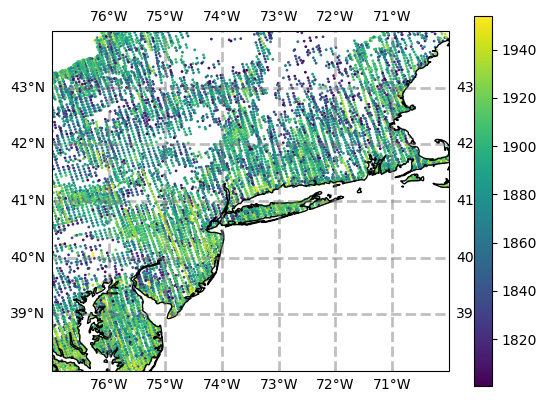

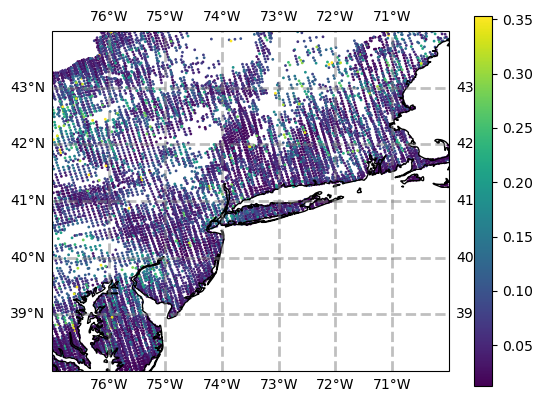

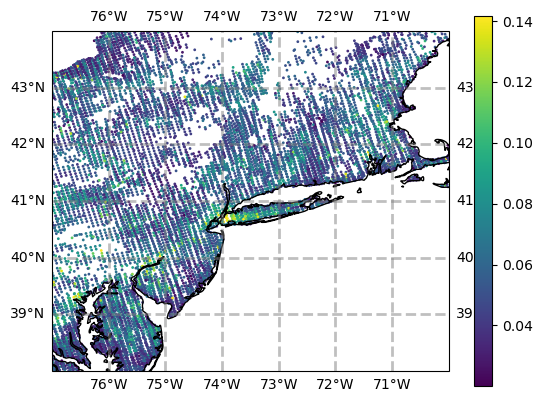

In [11]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
for fn in list(s5p.keys()):
    g = ax.scatter(s5p[fn]['lon'],s5p[fn]['lat'],c=s5p[fn]['xch4_bc'],s=1,transform=ccrs.PlateCarree())
plt.colorbar(g,ax=ax)
ax.plot(wrf_lon[0,:],wrf_lat[0,:],'k',transform=ccrs.PlateCarree())
ax.plot(wrf_lon[-1,:],wrf_lat[-1,:],'k',transform=ccrs.PlateCarree())
ax.plot(wrf_lon[:,0],wrf_lat[:,0],'k',transform=ccrs.PlateCarree())
ax.plot(wrf_lon[:,-1],wrf_lat[:,-1],'k',transform=ccrs.PlateCarree())
ax.set_xlim([lon_lb,lon_ub])
ax.set_ylim([lat_lb,lat_ub])
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

fig,ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
for fn in list(s5p.keys()):
    g = ax.scatter(s5p[fn]['lon'],s5p[fn]['lat'],c=s5p[fn]['aod'],s=1,transform=ccrs.PlateCarree())
plt.colorbar(g,ax=ax)
ax.plot(wrf_lon[0,:],wrf_lat[0,:],'k',transform=ccrs.PlateCarree())
ax.plot(wrf_lon[-1,:],wrf_lat[-1,:],'k',transform=ccrs.PlateCarree())
ax.plot(wrf_lon[:,0],wrf_lat[:,0],'k',transform=ccrs.PlateCarree())
ax.plot(wrf_lon[:,-1],wrf_lat[:,-1],'k',transform=ccrs.PlateCarree())
ax.set_xlim([lon_lb,lon_ub])
ax.set_ylim([lat_lb,lat_ub])
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

fig,ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
for fn in list(s5p.keys()):
    g = ax.scatter(s5p[fn]['lon'],s5p[fn]['lat'],c=s5p[fn]['alb'],s=1,transform=ccrs.PlateCarree())
plt.colorbar(g,ax=ax)
ax.plot(wrf_lon[0,:],wrf_lat[0,:],'k',transform=ccrs.PlateCarree())
ax.plot(wrf_lon[-1,:],wrf_lat[-1,:],'k',transform=ccrs.PlateCarree())
ax.plot(wrf_lon[:,0],wrf_lat[:,0],'k',transform=ccrs.PlateCarree())
ax.plot(wrf_lon[:,-1],wrf_lat[:,-1],'k',transform=ccrs.PlateCarree())
ax.set_xlim([lon_lb,lon_ub])
ax.set_ylim([lat_lb,lat_ub])
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

In [12]:
results_list = []
for ky in list(s5p.keys()):
    fn = s5p[ky]
    var_dict = {'lat':fn['lat'],'lon':fn['lon'],'datetime':fn['t'],'psfc':None,'pressure':None,'CH4_BCK':None,'CH4_ANT':None,'CH4_BIO':None}
    results_dict = sample_wrfout_profile(ID=ky,wrf_domain='d01',wrf_path='/work2/07655/tg869546/stampede3/nyc-chem/2023/wrfout/',var_dict=var_dict)
    results_list.append(results_dict)

In [13]:
n_obs = 0
for d in results_list:
    n_obs += d['lat'].shape[0]

In [14]:
xch4_ak = np.zeros(n_obs)
xch4_s5p = np.zeros(n_obs)
lats = np.zeros(n_obs)
lons = np.zeros(n_obs)
aods = np.zeros(n_obs)
albs = np.zeros(n_obs)
sza = np.zeros(n_obs)

iob = 0
for gr in results_list[:]:
    for job in range(gr['CH4_ANT'].shape[0]):
        var_dict = {}
        inds = np.where(1-np.isnan(gr['CH4_ANT'][job]))
        var_dict['prof_plevs'] = gr['pressure'][job,:]
        var_dict['mole_frac'] = gr['CH4_ANT'][job,:]
        var_dict['ak'] = s5p[gr['ID']]['ak'][job,:]
        var_dict['ch4_ap'] = s5p[gr['ID']]['ch4_ap'][job,:]
        tp = gr['psfc'][job,0]*np.linspace(0,1,s5p[gr['ID']]['ak'].shape[1]+1)[-1::-1]
        var_dict['ak_plevs'] = tp[:-1]+0.5*np.diff(tp)
        var_dict['psfc'] = gr['psfc'][job,0]
        xch4_ak[iob+job] = compute_ak_col_avg(var_dict=var_dict)
    xch4_s5p[iob:iob+gr['CH4_ANT'].shape[0]] = s5p[gr['ID']]['xch4_bc'][:]
    lons[iob:iob+gr['CH4_ANT'].shape[0]] = s5p[gr['ID']]['lon'][:]
    lats[iob:iob+gr['CH4_ANT'].shape[0]] = s5p[gr['ID']]['lat'][:]
    aods[iob:iob+gr['CH4_ANT'].shape[0]] = s5p[gr['ID']]['aod'][:]
    albs[iob:iob+gr['CH4_ANT'].shape[0]] = s5p[gr['ID']]['alb'][:]
    iob += gr['CH4_ANT'].shape[0]

Text(0.5, 1.0, 'S5P XCH4')

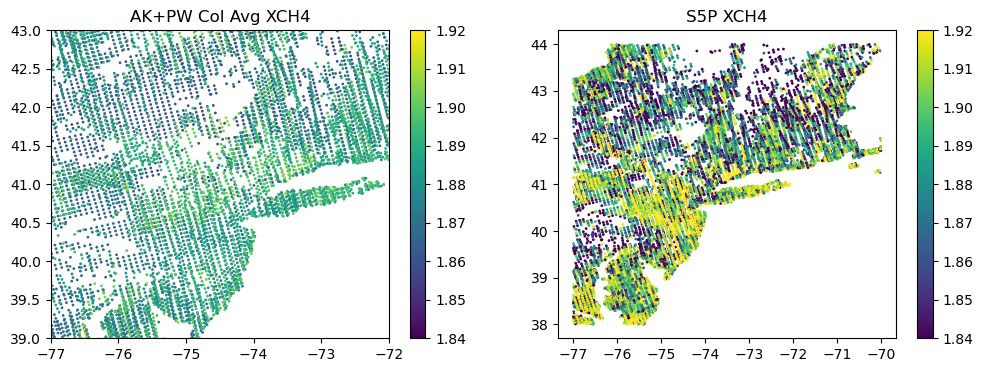

In [15]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax = axs[0]
g = ax.scatter(lons,lats,c=xch4_ak,vmin=1.84,vmax=1.92,s=1)
plt.colorbar(g,ax=ax)
ax.set_title('AK+PW Col Avg XCH4')
ax.set_xlim([-77,-72])
ax.set_ylim([39,43])

ax = axs[1]
g = ax.scatter(lons,lats,c=xch4_s5p/1e3,vmin=1.84,vmax=1.92,s=1)
plt.colorbar(g,ax=ax)
ax.set_title('S5P XCH4')

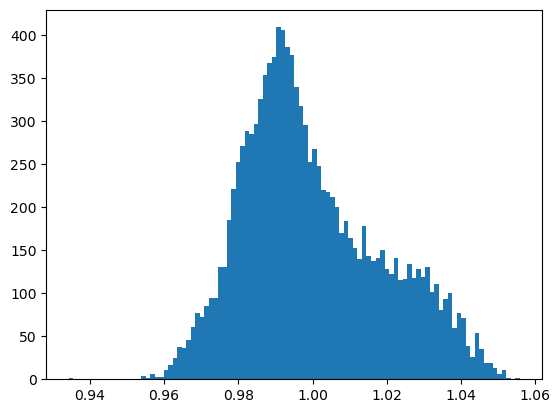

In [17]:
plt.hist(xch4_ak/xch4_s5p*1e3,bins=100);


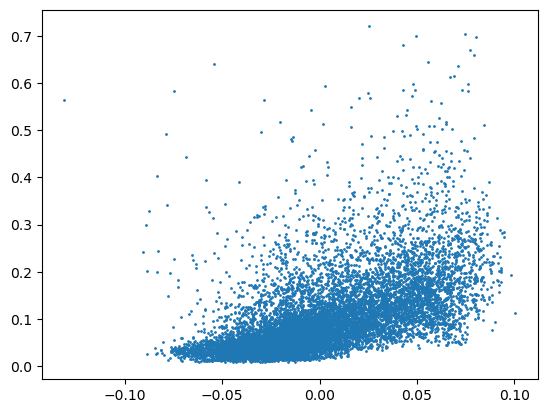

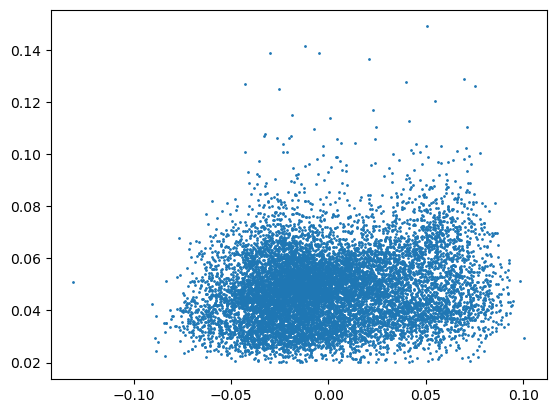

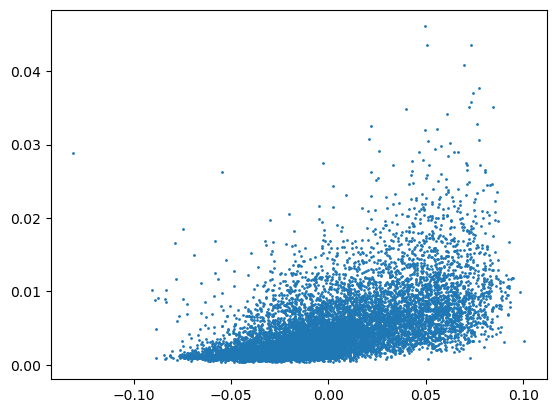

In [18]:
plt.scatter(xch4_ak-xch4_s5p/1e3,aods,s=1)
plt.figure()
plt.scatter(xch4_ak-xch4_s5p/1e3,albs,s=1)
plt.figure()
plt.scatter(xch4_ak-xch4_s5p/1e3,aods*albs,s=1)

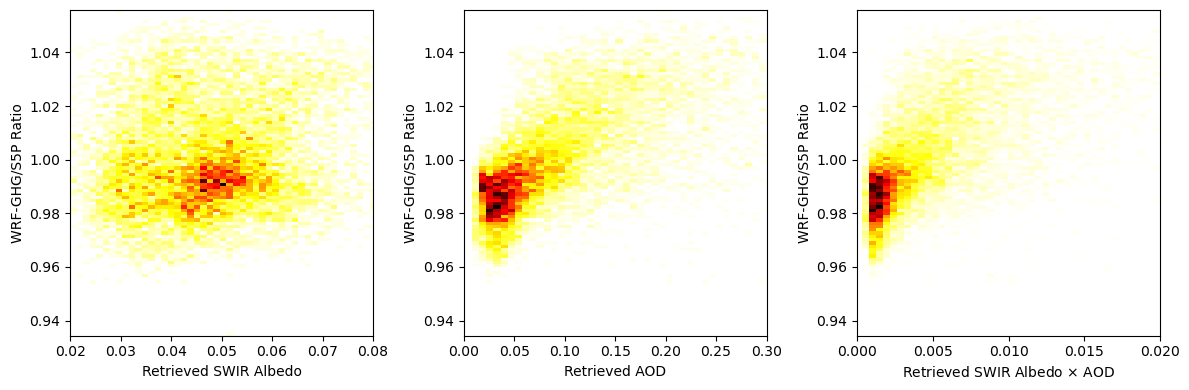

In [19]:
fig,axs = plt.subplots(1,3,figsize=(12,4))
ax = axs[0]
g = ax.hist2d(albs,xch4_ak/xch4_s5p*1e3,bins=100,cmap=plt.cm.hot_r);
ax.set_ylabel('WRF-GHG/S5P Ratio')
ax.set_xlabel('Retrieved SWIR Albedo')
ax.set_xlim([0.02,0.08])

ax = axs[1]
g = ax.hist2d(aods,xch4_ak/xch4_s5p*1e3,bins=100,cmap=plt.cm.hot_r);
ax.set_ylabel('WRF-GHG/S5P Ratio')
ax.set_xlabel('Retrieved AOD')
ax.set_xlim([0,0.3])

ax = axs[2]
g = ax.hist2d(albs*aods,xch4_ak/xch4_s5p*1e3,bins=100,cmap=plt.cm.hot_r);
ax.set_ylabel('WRF-GHG/S5P Ratio')
ax.set_xlabel(r'Retrieved SWIR Albedo $\times$ AOD')
ax.set_xlim([0,0.02])

plt.tight_layout()

0.9889066904116252


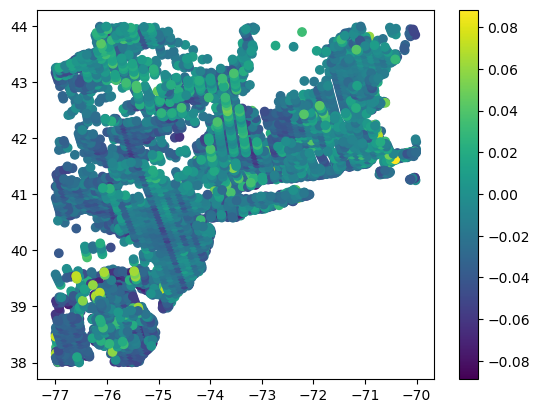

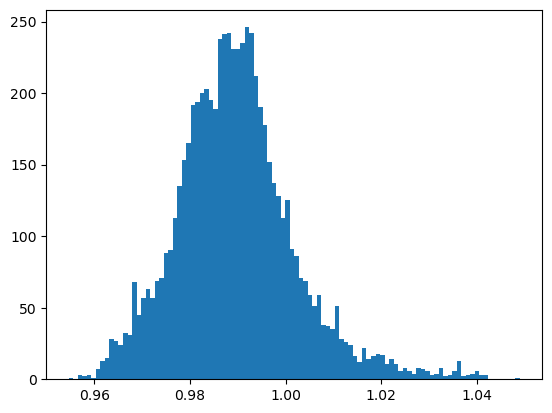

In [20]:
inds = np.where(aods < 0.08)
plt.figure()
plt.scatter(lons[inds],lats[inds],c=(xch4_ak-xch4_s5p/1e3)[inds])
plt.colorbar()
plt.figure()
plt.hist((xch4_ak/xch4_s5p*1e3)[inds],bins=100)
print(np.median((xch4_ak/xch4_s5p*1e3)[inds]))